---

**Lesson 3** of the YT course:

[***Machine Learning for Audio Signals in Python - MLfAS***](https://www.youtube.com/playlist?list=PL6QnpHKwdPYjfCH2zkMGEHu2kv1HTICYA)

Original Jupyter Notebooks by [*Renato Profeta*](https://www.youtube.com/c/GuitarsAI)

---

In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import time

device='cpu'
#device='cuda'

#Neural Networks for Classification

In [2]:
batch_size_train = 100
batch_size_test = 10
num_classes = 10  #10 classes according to the 10 possible digits 0,...,9

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', 
    train=True, download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_train, shuffle=True)
#the Normalize() arguments are mean and standard deviation.

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('~/Downloads/MNISTfiles/', 
                               train=False, download=True,
                               transform=torchvision.transforms.Compose(
                                   [torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=batch_size_test, shuffle=True)


Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/train-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw


Extracting /root/Downloads/MNISTfiles/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/Downloads/MNISTfiles/MNIST/raw
Processing...


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


X_train.type()= torch.FloatTensor y_train.type()= torch.LongTensor
batch_idx= 0 X_train.shape= torch.Size([100, 1, 28, 28]) y_train.shape= torch.Size([100]) y_train= tensor([8, 0, 1, 3, 4, 7, 6, 2, 7, 5, 9, 9, 3, 6, 3, 2, 9, 7, 3, 6, 9, 4, 1, 5,
        3, 5, 8, 5, 7, 0, 0, 5, 1, 6, 0, 5, 1, 8, 1, 5, 2, 9, 3, 6, 9, 2, 0, 6,
        7, 1, 4, 3, 1, 1, 3, 7, 8, 2, 7, 8, 1, 1, 7, 6, 5, 2, 4, 3, 1, 1, 2, 9,
        2, 3, 7, 0, 0, 9, 2, 4, 1, 5, 4, 7, 7, 3, 9, 6, 5, 6, 2, 7, 8, 7, 1, 1,
        7, 0, 5, 2])


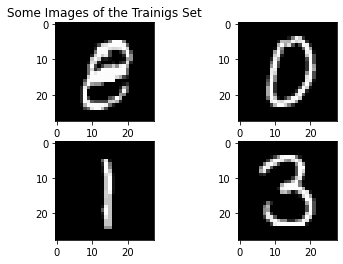

In [3]:
examples = enumerate(train_loader)
# Plot ad hoc mnist instances

# load (downloaded if needed) the MNIST dataset
#(X_train, y_train), (X_test, y_test) = mnist.load_data()
#one batch of 100 images:
batch_idx, (X_train, y_train) = next(examples)
print( "X_train.type()=",X_train.type(), "y_train.type()=",y_train.type())
#Observe that the input signal, the images, have the type torch.FloatTensor, 
#whereas the target, the correct digit class indices, have the type torch.LongTensor! 
#This difference in Types becomes important when we apply a loss function.
print("batch_idx=", batch_idx, "X_train.shape=", X_train.shape, "y_train.shape=", y_train.shape, "y_train=", y_train)
#the first index is for the image (100 images), the 2nd index is for the batch and only contains 1 batch, 
#and the remaining 2 indices are for the 28 pixels vertically and horizontally, respectively.
#the shape of the target y is a 1-dimensional array of 100 entries
examples = enumerate(test_loader)
#one batch of 100 images:
batch_idx, (X_test, y_test) = next(examples)

# plot 4 images as gray scale
plt.subplot(221)
plt.title("Some Images of the Trainigs Set")
plt.imshow(X_train[0,0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train[1,0], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train[2,0], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train[3,0], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

#X_train[0,0]: Index "1" is the index of the image, index "0" is for the current batch or set of images 
#(in our example we only have batch 0), and the remaining 2 indices to the right, which are not seen here, 
#are the image pixel indices

In [4]:
X_testunflat=X_test.clone() #keep original for imshow later
# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[2] * X_train.shape[3]

In [5]:
#Flatten the images:
X_train = X_train.view(X_train.shape[0], num_pixels) # X_train.shape[0] is the number of images in the batch
print("X_train.shape=",X_train.shape)
X_test = X_test.reshape(X_test.shape[0], num_pixels)
print("X_test.shape=",X_test.shape)

#Observe that we don't need to reshape the target, because that is already a 1-dimensional array of the correct classes

# normalize inputs from 0-255 to 0-1
#X_train = X_train / 255
#X_test = X_test / 255

# one hot encode outputs
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)


X_train.shape= torch.Size([100, 784])
X_test.shape= torch.Size([10, 784])


In [6]:
# define the neural network model
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.layer1=nn.Sequential(nn.Linear(in_features=num_pixels, out_features=num_pixels))
        self.layer2=nn.Sequential(nn.Linear(in_features=num_pixels, out_features=num_classes))
      
   
    def forward(self, x):
        x = F.relu(self.layer1(x))  #First layer with activation function
        x = self.layer2(x)   #Second layer
        #x = torch.nn.Softmax(x)
        return x
      
#Here we choose the size of the hidden layer (the output of layer 1) the same as the number of 
#pixels at the input, but it could also be a different number

In [7]:
# build the model
print("Generate Model:")
model = DenseNet()#.to('cpu')
    
loss_fn = nn.CrossEntropyLoss() #The "CrossEntropyLoss" is made for classification tasks
#it expects the data type torch.FloatTensor from the 10 outputs of our neural network (which fits), 
#and torch.LongTensor as data type for the target data, which again fits! 
#learning_rate = 1e-4
#THEORY NOTE: It basically first applies a SoftMax function to the 10 outputs of our neural network, 
#and turns them into probabilities, such that they always sum up to 1 (it also applies a logarithm because 
#that is part of the cross entropy calculation, and to make the optimization more precise for very small values).

optimizer = torch.optim.Adam(model.parameters())#, lr=learning_rate)

# Fit the model
X_train=X_train.to(device)
y_train=y_train.to(device)
starttime=time.time()
for epoch in range(10):
    Ypred=model(X_train)
    loss=loss_fn(Ypred, y_train)
    if epoch%2==0:
        print(epoch, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
       
endtime=time.time()
print("Duration of optimization:", endtime-starttime)
#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, batch_size=200, verbose=2)

Generate Model:
0 2.28505539894104
2 1.144896388053894
4 0.5574789643287659
6 0.27867743372917175
8 0.1354937106370926
Duration of optimization: 0.32131290435791016


In [8]:
# Final evaluation of the model
Ypred=model(X_test)
loss=loss_fn(Ypred, y_test)
#scores = model.forward(X_test, y_test, verbose=0)
print("Loss on the test set:", loss)

Loss on the test set: tensor(0.3901, grad_fn=<NllLossBackward>)


In [9]:
torch.save({'model_state_dict': model.state_dict(),
       'optimizer_state_dict': optimizer.state_dict()}, "mnistexample_pytorch_weights.torch")
print("Wrote to mnistexample_pytorch_weights.torch")

Wrote to mnistexample_pytorch_weights.torch


sample.shape= torch.Size([784])
Test Ypred= tensor([-3.5430,  0.6835, -1.5545,  4.2671,  0.0249,  1.0498, -2.3266, -0.0409,
        -1.1215, -1.7402], grad_fn=<AddBackward0>)
prediction= tensor(3)


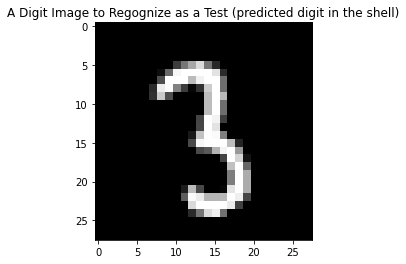

In [10]:
#"Inference", predict an example digit test image:
plt.imshow(X_testunflat[1,0], cmap=plt.get_cmap('gray'))
plt.title("A Digit Image to Regognize as a Test (predicted digit in the shell)")

sample=X_test[1,:]
print("sample.shape=", sample.shape)
Ypred=model(sample)
print("Test Ypred=", Ypred)
prediction=torch.argmax(Ypred) #use argmax as the class with the largest output
print("prediction=", prediction)

plt.show()

#When we apply the trained network (which is called "inference", as opposed to "training"), 
#instead of the Softmax we can simply take the argmax function, which returns the index with the largest 
#output (or probability) (see prediction=torch.argmax(Ypred))

#Unknown Test Image

In [15]:
import cv2
import numpy as np

In [17]:
#To test this case of an unknown image, we generate a 28x28 picture containing just random numbers between 0 and 1 (or 0 and 255 in a jpeg image).
rpic=np.random.rand(28,28)*255 #range for 8 bit unsigned integer
cv2.imwrite("./randpic.jpg", rpic);

Picture  0
sample.shape= torch.Size([784])
Test Ypred= tensor([-3.5430,  0.6835, -1.5545,  4.2671,  0.0249,  1.0498, -2.3266, -0.0409,
        -1.1215, -1.7402], grad_fn=<AddBackward0>)
Probabilities: tensor([3.6625e-04, 2.5082e-02, 2.6755e-03, 9.0298e-01, 1.2982e-02, 3.6175e-02,
        1.2361e-03, 1.2155e-02, 4.1251e-03, 2.2220e-03])
prediction= tensor(3)


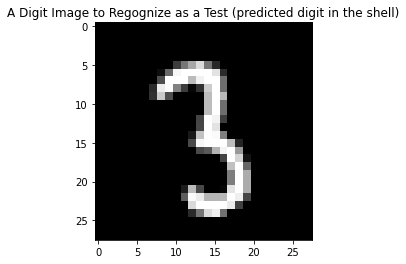

Picture  1
sample.shape= torch.Size([784])
Test Ypred= tensor([ 0.5988, -1.0392,  0.0139, -0.7186, -0.3097, -0.0570,  0.2086, -0.1534,
         0.0128, -0.1995], grad_fn=<AddBackward0>)
Probabilities: tensor([0.1962, 0.0381, 0.1093, 0.0526, 0.0791, 0.1018, 0.1328, 0.0925, 0.1092,
        0.0883])
prediction= tensor(0)
Probably not a digit


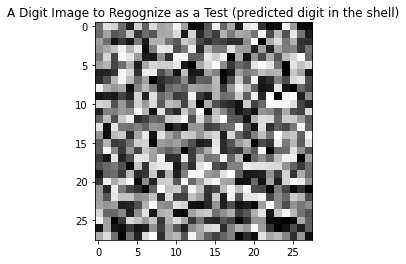

In [18]:
#We extend our main program section such that it inlcudes reading our random jpeg image for testing after it took an image from the MNIST test set

#"Inference", predict an example digit test image:
for pic in range(2):
    print("Picture ", pic)
    if pic==0: #take image from test set:
        X_testorig=X_testunflat[1,0]
        sample=X_test[1,:]
    if pic==1: #read externa random test image, size 28x28 pixel:
        from PIL import Image
        image = Image.open('./randpic.jpg')
        import torchvision.transforms.functional as TF
        X_testorig = TF.to_tensor(image)
        X_testorig = X_testorig[0,:,:]
        sample=X_testorig.view(28*28)
        
    plt.imshow(X_testorig, cmap=plt.get_cmap('gray'))
    plt.title("A Digit Image to Regognize as a Test (predicted digit in the shell)")

    print("sample.shape=", sample.shape)
    Ypred=model(sample)
    sm = torch.nn.Softmax(dim=0)
    print("Test Ypred=", Ypred)
    probabilities = sm(Ypred.detach())
    print("Probabilities:",probabilities)
    prediction=torch.argmax(probabilities) #use argmax as the class with the largest output
    print("prediction=", prediction)
    if probabilities[prediction] <0.8 : #not confident
        print("Probably not a digit")
    plt.show()